In [1]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels import discrete
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [2]:
"""
2nd model (dropped: embarked)
aic = 757
bic = 844
r2 = 0.443
"""

data = sns.load_dataset('titanic')
df = data
df = df.drop(['survived','alive','embark_town','alone', 'adult_male', 'class', 'deck','sex'], 1)

# fares which appear to be accumlated (from 3rd class)
accum_fares = {69.5500, 56.4958, 46.9000, 39.6875, 34.3750, 31.3875, 31.2750, 29.1250, 27.9000,25.466700, 24.150000, 23.450000,23.250000, 21.075,20.525000, 19.2583}

# for each val in accum_fares...
for e in accum_fares:
    # init df2 (df with 3rd class only)
    df2 = df.loc[df['pclass'] == 3]
    # trim so fare == e
    df2 = df2.loc[df2['fare'] == e]
    # filter by embarked for cases with multiple groups from dif towns
    for t in df2['embarked'].unique():
        df2_t = df2.loc[df2['embarked'] == t]
        # divide fare by # of people
        df2_t['fare'] = df2_t['fare'] / len(df2_t)
        # update df with df2 vals
        for index in df2_t.index:
            df.loc[index, 'fare'] = df2_t.loc[index, 'fare']
            
df = df.drop('embarked', 1)

# for dummies, prefer to drop: southhampton, man
to_dummy = ['who','pclass']
to_poly = ['age', 'sibsp', 'fare', 'parch']


#hacked solution to replace nans and capture cols replaced with a dummy
df['age'] = df['age'].fillna(3.33333)
df['was_nan'] = (df.age == 3.33333).astype(int)
# 29.6 is ~avg age
df.age = df.age.replace(3.33333, 29.6)

# build dummies
dum = pd.get_dummies(data=df, columns=to_dummy)
x = dum.drop(['who_man', 'pclass_3'], 1)

# build square/cube feat
for e in to_poly:
    x[e + '_2'] = x[e]**2
    x[e + '_3'] = x[e]**3

y = data.survived
x = sm.add_constant(x)
mod = sm.OLS(y,x).fit(cov_type='HC2')
mod.summary()

<ipython-input-2-d1b8f2118442>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_t['fare'] = df2_t['fare'] / len(df2_t)
C:\Users\Sasha\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 16
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     70.44
Date:                Mon, 08 Feb 2021   Prob (F-statistic):          8.20e-145
Time:                        14:14:37   Log-Likelihood:                -360.89
No. Observations:                 891   AIC:                             757.8
Df Residuals:                     873   BIC:                             844.0
Df Model:                          17                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2011      0.142      1.420      0.155      -0.076       0.479
age           -0.0080      0.013     -0.619      0.536      -0.033       0.017
sibsp          0.0759      0.046      1.636      0.102      -0.015       0.167
parch          0.0023      0.077      0.031      0.976      -0.148       0.153
fare           0.0022      0.002      1.368      0.171      -0.001       0.005
was_nan        0.0023      0.035      0.067      0.947      -0.066       0.070
who_child      0.5315      0.102      5.203      0.000       0.331       0.732
who_woman      0.5632      0.032     17.502      0.000       0.500       0.626
pclass_1       0.2686      0.062      4.301      0.000       0.146       0.391
pclass_2       0.1194      0.033      3.566      0.000       0.054       0.185
age_2          0.0002      0.000      0.422      0.673      -0.001       0.001
age_3      -1.551e-06   3.66e-06     -0.423      0.672   -8.73e-06    5.63e-06
sibsp_2       -0.0864      0.022     -3.998      0.000      -0.129      -0.044
sibsp_3        0.0090      0.002      4.219      0.000       0.005       0.013
fare_2     -1.487e-05   8.76e-06     -1.697      0.090    -3.2e-05     2.3e-06
fare_3      2.456e-08   1.21e-08      2.023      0.043    7.63e-10    4.83e-08
parch_2       -0.0040      0.047     -0.085      0.932      -0.097       0.089
parch_3       -0.0022      0.006     -0.339      0.734      -0.015       0.010
==============================================================================
Omnibus:                       51.573   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.520
Skew:                           0.565   Prob(JB):                     4.38e-14
Kurtosis:                       3.616   Cond. No.                     1.07e+08
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
from sklearn.linear_model import LogisticRegression
est = sm.Logit(y, x).fit()
model=LogisticRegression().fit(x,y)

y_pred = model.predict(x)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
tp + tn / (tn+fp+fn+ tp)

Optimization terminated successfully.
         Current function value: 0.410974
         Iterations 11


82.5925925925926

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [4]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
# use sklearn `train_test_split`
x, y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [5]:
# standard scalar()
# fit_transform(xtrain)
# transform(xtest)
# logmodel.fit(xtrain,ytrain)
# model.score(xtest,ytest)

#add poly features
#add regularization (lasso)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)
model = LogisticRegression(max_iter=5000).fit(X_std,y_train)

In [6]:
model.score(X_test, y_test)

0.8288744588744589

In [7]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(interaction_only=True)
# X_p = poly.fit_transform(X_train)
# X_p_std = scaler.fit_transform(X_p)

# says it needs ~108 GiB lol

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [8]:
"""
Y: Fish caught
X: Livebait, camper, persons, children
Proposal: Zero-inflated poisson regression
"""

data_url = 'data/fish.csv'
dataframe = pd.read_csv(data_url)
df = dataframe
Y = df.FISH_COUNT
X = df.copy()
X = sm.add_constant(X.drop('FISH_COUNT',1))

est = discrete.count_model.ZeroInflatedPoisson(Y, X, Inflation='Logit').fit(cov_type='HC2')
est.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22


C:\Users\Sasha\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Mon, 08 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         14:17:08   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:                   HC2   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.706     -3.587      0.000      -3.916      -1.149
LIVE_BAIT         1.7086      0.398      4.291      0.000       0.928       2.489
CAMPER            0.6745      0.367      1.839      0.066      -0.045       1.393
PERSONS           0.8752      0.163      5.362      0.000       0.555       1.195
CHILDREN         -1.3957      0.318     -4.387      0.000      -2.019      -0.772
=================================================================================
"""

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

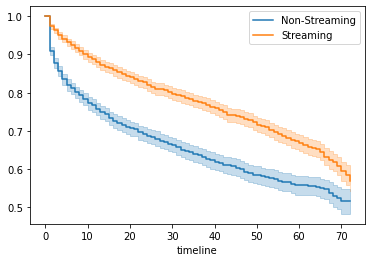

In [188]:
from lifelines import KaplanMeierFitter

data_url = 'data/telco_churn.csv'
dataframe = pd.read_csv(data_url)
df = dataframe

# group: Steaming TV 
# event: churn
# time: tenure
# for 5.2: CoxPHFitter

# cleaning
df = df[df['StreamingTV'] != 'No internet service'].copy()
df.loc[(df.StreamingTV == ('No')),'StreamingTV'] = 0
df.loc[(df.StreamingTV == ('Yes')),'StreamingTV'] = 1
df['StreamingTV'] = df['StreamingTV'].astype(int)

df.loc[(df.Churn == ('No')),'Churn'] = 0
df.loc[(df.Churn == ('Yes')),'Churn'] = 1
df['Churn'] = df['Churn'].astype(int)

# data engineering
Time = df['tenure']
Event = df['Churn']
# bool mask/filter for Streaming/Non-Streaming
STV = (df['StreamingTV'] == 1).astype(bool)

# visualization
kmf = KaplanMeierFitter()
kmf.fit(Time[~STV], Event[~STV], label='Non-Streaming')
# ~STV == Non-Streaming
ax = kmf.plot_survival_function()

kmf.fit(Time[STV], Event[STV], label='Streaming')
ax = kmf.plot_survival_function(ax=ax)

In [189]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [266]:
df2 = df.copy()
df3 = df.copy()
# make a white list filter, then invert it as a black list filter
# eg. 'drop all these as df2' and 'drop all NOT these as df3'
q =['tenure','MonthlyCharges','TotalCharges']
k = df2.columns.isin(q)


#df2 is to_dummy features
df2 = df2.drop(df2.columns[k],1)
df2 = df2.drop('customerID',1)
#df3 is to_poly features (but also tenure which is target i think)
df3 = df3.drop(df3.columns[~k],1)

for c in df2.columns:
    dummies = pd.get_dummies(df[c], drop_first=True, prefix=c)
    df2 = df2.drop(c, 1)
    df2 = df2.join(dummies)

df3 = df3[df3['TotalCharges'] != ' ']
df3['TotalCharges'] = df3['TotalCharges'].astype(float)
# df3 = df3.drop(['TotalCharges'], 1)  # 'MonthlyCharges',
# for c in df3.columns:
#     df3[c] = df3[c].astype(float)
#     df3[c + '_2'] = df3[c]**2

X = pd.concat([df3,df2[['Churn_1']]], axis=1)
# X = sm.add_constant(X)
df2.columns

Index(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_1', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_1'],
      dtype='object')

In [247]:
corr = X.corr()
corr[(corr>=.8) & (corr<1)].sum()

tenure            0.931935
MonthlyCharges    0.000000
TotalCharges      0.931935
Churn_1           0.000000
dtype: float64

<lifelines.CoxPHFitter: fitted with 5512 total observations, 3756 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_1'
      baseline estimation = breslow
   number of observations = 5512
number of events observed = 1756
   partial log-likelihood = -12896.00
         time fit was run = 2021-02-11 00:44:57 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
MonthlyCharges                         -0.05       0.95       0.00            -0.06            -0.04                 0.95                 0.96
SeniorCitizen_1                        -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.05
Contract_Two year                      -2.98       0.05       0.17            -3.32            -2.64                 0.04                 0.07
Contract_One year                      -1.56       0.21       0.09            -1.74            -1.38                 0.18                 0.25
TechSupport_Yes                        -0.21       0.81       0.07            -0.35            -0.08                 0.70                 0.93
Partner_Yes                            -0.57       0.57       0.05            -0.67            -0.46                 0.51                 0.63
StreamingTV_1                           0.53       1.70       0.08             0.38             0.68                 1.46                 1.98
InternetService_Fiber optic             1.56       4.78       0.14             1.29             1.83                 3.65                 6.25
PaperlessBilling_Yes                    0.19       1.20       0.06             0.07             0.30                 1.07                 1.35
PaymentMethod_Credit card (automatic)  -0.53       0.59       0.07            -0.67            -0.39                 0.51                 0.68
OnlineSecurity_Yes                     -0.50       0.60       0.07            -0.64            -0.37                 0.53                 0.69
DeviceProtection_Yes                   -0.10       0.90       0.06            -0.22             0.02                 0.80                 1.02
PhoneService_Yes                        0.94       2.56       0.13             0.68             1.20                 1.98                 3.32

                                           z      p   -log2(p)
covariate                                                     
MonthlyCharges                        -11.10 <0.005      92.62
SeniorCitizen_1                        -1.10   0.27       1.88
Contract_Two year                     -17.15 <0.005     216.49
Contract_One year                     -17.26 <0.005     219.32
TechSupport_Yes                        -3.04 <0.005       8.71
Partner_Yes                           -10.94 <0.005      90.16
StreamingTV_1                           6.77 <0.005      36.21
InternetService_Fiber optic            11.38 <0.005      97.21
PaperlessBilling_Yes                    3.16 <0.005       9.29
PaymentMethod_Credit card (automatic)  -7.35 <0.005      42.23
OnlineSecurity_Yes                     -7.21 <0.005      40.69
DeviceProtection_Yes                   -1.67   0.09       3.40
PhoneService_Yes                        7.11 <0.005      39.66
---
Concordance = 0.84
Partial AIC = 25817.99
log-likelihood ratio test = 2741.89 on 13 df
-log2(p) of ll-ratio test = inf

None


<AxesSubplot:xlabel='log(HR) (95% CI)'>

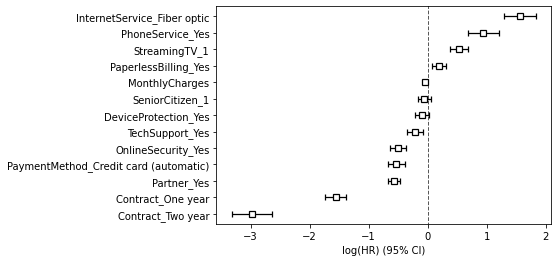

In [279]:

X = pd.concat([df3,df2[['Contract_Two year','Contract_One year','TechSupport_Yes','Partner_Yes','StreamingTV_1','Churn_1','InternetService_Fiber optic','PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'OnlineSecurity_Yes', 'DeviceProtection_Yes', 'PhoneService_Yes']]], axis=1)
X = X.dropna()
X = X.drop(['TotalCharges'], 1)
X
# 'SeniorCitizen_1', 'Dependents_Yes',

from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(X, 'tenure', event_col='Churn_1')
print(cph.print_summary())
cph.plot()


<AxesSubplot:>

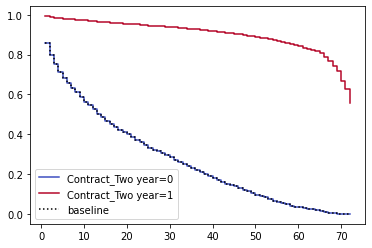

In [283]:
cph.plot_partial_effects_on_outcome(covariates='Contract_Two year', values=[0, 1], cmap='coolwarm')

<AxesSubplot:>

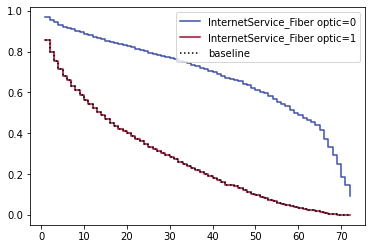

In [284]:
cph.plot_partial_effects_on_outcome(covariates='InternetService_Fiber optic', values=[0, 1], cmap='coolwarm')